ToDo:
* Would shuffling prior to training help?
* Why does Keras fit method give better results than the tf implementation?
* Mean  and  standard  deviation  of  the  return  over  multiple  rollouts  in  a table
* What rewards function is hard-coded in the environments?

In [1]:
%env MUJOCO_PY_MJKEY_PATH=/home/had/rl/mjpro131/bin/mjkey.txt
%env MUJOCO_PY_MJPRO_PATH=/home/had/rl/mjpro131

env: MUJOCO_PY_MJKEY_PATH=/home/had/rl/mjpro131/bin/mjkey.txt
env: MUJOCO_PY_MJPRO_PATH=/home/had/rl/mjpro131


In [21]:
import pickle
import tensorflow as tf
import numpy as np
import tf_util
import gym
import load_policy
import matplotlib.pyplot as plt

import miscellaneous as msc

from tqdm import tqdm

import pandas as pd

In [3]:
envname = "Hopper-v1"
expert_policy_file = "experts/" + envname + ".pkl"
render = False
num_rollouts = 20

In [4]:
policy = load_policy.load_policy(expert_policy_file);

('obs', (1, 11), (1, 11))


SET UP tensorflow    

In [5]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [7]:
observations = []
actions = []
rewards = []
steps_numbers = []
env = gym.make(envname)

for i in tqdm(range(num_rollouts)):
    observations_rollout, actions_rollout, total_reward, number_steps = msc.rollout(env, policy, render)
    observations += observations_rollout
    actions += actions_rollout
    rewards.append(total_reward)
    steps_numbers.append(number_steps)
    

[2017-09-22 18:44:06,254] Making new env: Hopper-v1
100%|██████████| 20/20 [00:15<00:00,  1.31it/s]


In [8]:
expert_data = {'observations': np.array(observations),
                'actions': np.array(actions),
                'returns': np.array(rewards),
                'steps': np.array(steps_numbers)}

Train policy

In [9]:
def baseline_model(input_dimension, output_dimension):
    model = Sequential()
    model.add(Dense(input_dimension/2, input_dim=input_dimension, init='normal', activation='relu'))
    model.add(Dense(output_dimension, init='normal'))

    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    return model

In [10]:
import random
from keras.models import Sequential
from keras.layers import Dense, Lambda

observations_array = np.array(observations)
input_dimension = observations_array.shape[1]
actions_array = np.array(actions)
output_dimension = actions_array.shape[2]

policy = baseline_model(input_dimension, output_dimension)
history = policy.fit(observations_array, actions_array.reshape(-1, output_dimension), epochs=20)

Using TensorFlow backend.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(5, activation="relu", kernel_initializer="normal", input_dim=11)`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(3, kernel_initializer="normal")`
  after removing the cwd from sys.path.


Epoch 1/20
20000/20000 [==============================] - 1s - loss: 1.2175 - mean_absolute_error: 0.7943     
Epoch 2/20
20000/20000 [==============================] - 1s - loss: 0.4155 - mean_absolute_error: 0.4372     
Epoch 3/20
20000/20000 [==============================] - 1s - loss: 0.2567 - mean_absolute_error: 0.3311     
Epoch 4/20
20000/20000 [==============================] - 0s - loss: 0.2051 - mean_absolute_error: 0.3022     
Epoch 5/20
20000/20000 [==============================] - 1s - loss: 0.1689 - mean_absolute_error: 0.2800     
Epoch 6/20
20000/20000 [==============================] - 0s - loss: 0.1420 - mean_absolute_error: 0.2631     
Epoch 7/20
20000/20000 [==============================] - 0s - loss: 0.1257 - mean_absolute_error: 0.2498     
Epoch 8/20
20000/20000 [==============================] - 1s - loss: 0.1134 - mean_absolute_error: 0.2376     
Epoch 9/20
20000/20000 [==============================] - 0s - loss: 0.1021 - mean_absolute_error: 0.2255     
E

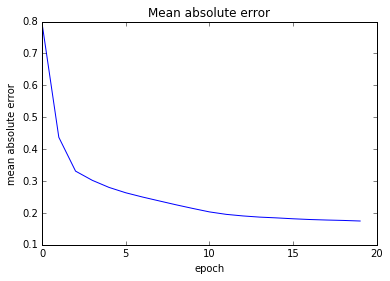

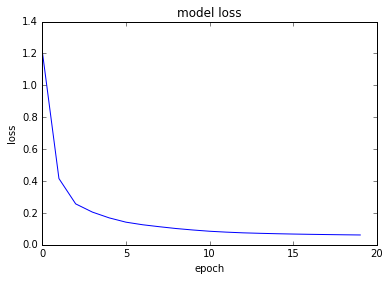

In [11]:
#  "Mean absolute error"
plt.plot(history.history['mean_absolute_error'])
plt.title('Mean absolute error')
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()


In [12]:
rewards = []
observations = []
actions = []
steps_numbers = []
max_steps = env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')
render = False

for i in tqdm(range(num_rollouts)):
    obs = env.reset()
    done = False
    totalreward = 0.
    steps = 0
    while not done:
        action = policy.predict(obs[None, :])
        observations.append(obs)
        actions.append(action)
        obs, reward, done, info = env.step(action)
        totalreward += reward
        steps += 1
        if render:
            env.render()
        if steps >= max_steps:
            break
    steps_numbers.append(steps)
    rewards.append(totalreward)

trained_policy_data = {'observations': np.array(observations),
                'actions': np.array(actions),
                'returns': np.array(rewards),
                'steps': np.array(steps_numbers)}

100%|██████████| 20/20 [00:02<00:00,  8.15it/s]


In [23]:
def one_data_table_stats(data):
    mean = data['returns'].mean()
    std = data['returns'].std()
    x = data['steps']
    pct_full_steps =  (x / x.max()).mean()

    return pd.Series({
        'mean reward': mean,
        'std reward': std,
        'pct full rollout': pct_full_steps
    })

In [24]:
df = pd.DataFrame({
    'expert': one_data_table_stats(expert_data),
    'imitation': one_data_table_stats(trained_policy_data)
})

In [25]:
print ("Analyzing experiment " + envname)
print (df)

Analyzing experiment Hopper-v1
                       expert   imitation
mean reward       3777.431038  270.129102
pct full rollout     1.000000    0.100000
std reward           3.521239    2.589173
